In [4]:
!pip install torch pandas numpy matplotlib seaborn scikit-learn 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.0 MB/s eta 0:00:0000:0100:10m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 224.9 kB/s eta 0:00:0000:0100:21
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 456.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 473.9 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 2.2 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.3 MB/s eta 0:00:0000:0100:07m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 2.0 MB/s eta 0:00:0000:0100:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 1.5 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 2.6 MB/s eta 0:00:0000:0100:03m
   ━━━━━━━━━━━━━━━

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
import joblib

df = pd.read_csv("aircraft-data_nov_dec.csv")
df.head()

,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted
0,SIS300,N300NJ,-118.213,34.5823,20175,BOMBARDIER INC,BD-100-1A10,1/31/24,PUNTA PACIFICO I LLC,BAKERSFIELD,CALIFORNIA,1077.0,474,11/7/22 13:30
1,UAL1434,N67501,-117.937,34.6038,36700,BOEING,737-9,4/30/24,UNITED AIRLINES INC,CHICAGO,ILLINOIS,7730.0,523,11/7/22 13:30
2,SWA3287,N483WN,-118.035,34.6345,13225,BOEING,737-7H4,8/31/24,SOUTHWEST AIRLINES CO,DALLAS,TEXAS,4770.0,380,11/7/22 13:30
3,AAL2059,N660AW,-118.075,34.4643,33750,AIRBUS INDUSTRIE,A320-232,2/29/24,US BANK NA TRUSTEE,BOSTON,MASSACHUSETTS,1751.0,527,11/7/22 13:30
4,N84PJ,N84PJ,-117.756,34.6002,34725,DASSAULT,FALCON 2000EX,12/31/24,HAMPTON AIRWAYS INC,SELLERSBURG,INDIANA,6054.0,525,11/7/22 13:40


In [ ]:
# Convert timestamps
df['spotted'] = pd.to_datetime(df['spotted'])
df = df.sort_values(by=['flight', 'spotted'])

# Calculate rate of change features
df['alt_rate'] = df.groupby('flight')['alt'].diff() / df.groupby('flight')['spotted'].diff().dt.total_seconds()
df['mph_rate'] = df.groupby('flight')['mph'].diff() / df.groupby('flight')['spotted'].diff().dt.total_seconds()

df.head(20)

,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted,alt_rate,mph_rate,phase,label
69,0,N72NG,-118.159,34.5726,7925,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4654.0,196,2022-11-07 15:50:00,NaN,NaN,Cruise,1
94,0,N77NG,-118.088,34.5609,7250,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4775.0,256,2022-11-07 16:40:00,-0.225000,0.020000,Cruise,1
109,0,N77NG,-118.150,34.4700,11000,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4743.0,320,2022-11-07 17:10:00,2.083333,0.035556,Climb,0
113,0,N72NG,-118.105,34.6085,4200,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4763.0,460,2022-11-07 17:30:00,-5.666667,0.116667,Descent,2
252,0,N72NG,-118.168,34.5182,7500,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4643.0,242,2022-11-08 06:30:00,0.070513,-0.004658,Cruise,1
268,0,N77NG,-117.935,34.5764,6375,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4735.0,242,2022-11-08 07:20:00,-0.375000,0.000000,Cruise,1
280,0,N77NG,-118.084,34.6583,11025,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4774.0,265,2022-11-08 07:50:00,2.583333,0.012778,Climb,0
288,0,N401SY,-117.970,34.6917,24500,LEARJET INC,60,10/31/25,TOP AIR TEXAS LLC,GLENDALE,CALIFORNIA,2075.0,470,2022-11-08 08:10:00,11.229167,0.170833,Climb,0
318,0,N257EB,-117.521,34.6900,38375,HAWKER BEECHCRAFT CORP,400A,4/30/25,HUSKER AVIATION LLC,CASPER,WYOMING,1675.0,502,2022-11-08 09:00:00,4.625000,0.010667,Climb,0
470,0,N72NG,-118.141,34.6797,6900,TEXTRON AVIATION INC,B300,5/31/25,NORTHROP GRUMMAN SYSTEMS CORP,EL SEGUNDO,CALIFORNIA,4636.0,460,2022-11-08 14:10:00,-1.692204,-0.002258,Descent,2


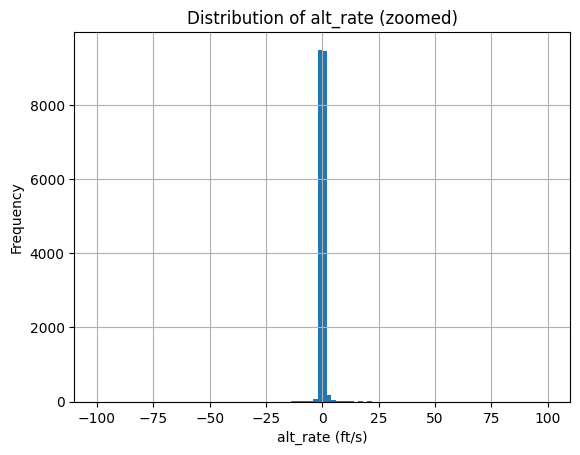

In [ ]:
import matplotlib.pyplot as plt
df['alt_rate'].hist(bins=100, range=(-10, 10))
plt.title('Distribution of alt_rate (zoomed)')
plt.xlabel('alt_rate (ft/s)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Label generation based on alt_rate
alt_rate_std = df['alt_rate'].std()
threshold = 1.5 * alt_rate_std 

def label_phase(row):
    if row['alt_rate'] > threshold:
        return "Climb"
    elif row['alt_rate'] < -threshold:
        return "Descent"
    else:
        return "Cruise"

df['phase'] = df.apply(label_phase, axis=1)

# Now drop any missing rows
df.dropna(subset=['alt', 'mph', 'alt_rate', 'mph_rate', 'phase', 'flight', 'spotted'], inplace=True)

# Encode target label
le = LabelEncoder()
df['label'] = le.fit_transform(df['phase'])

# Remove inf/-inf caused by division by zero
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any remaining NaNs
df.dropna(subset=['alt', 'mph', 'alt_rate', 'mph_rate', 'phase', 'flight', 'spotted'], inplace=True)

features = ['alt', 'mph', 'alt_rate', 'mph_rate']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


# Reshape for LSTM [samples, timesteps, features]
# Group by flight and form sequences
X_seq, y_seq = [], []
for flight, group in df.groupby('flight'):
    group = group.sort_values('spotted')
    if len(group) >= 10:
        X_flight = scaler.transform(group[features])
        y_flight = group['label'].values
        for i in range(len(group) - 9):
            X_seq.append(X_flight[i:i+10])
            y_seq.append(y_flight[i+9])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [ ]:
input_size = 4
hidden_size = 64
num_layers = 2
num_classes = 3
learning_rate = 0.001
num_epochs = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Training...")
model.train()
for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Evaluating...")
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the LSTM model on the test set: {100 * correct / total:.2f}%")

Training...
Epoch [1/15], Step [10/174], Loss: 0.8878
Epoch [1/15], Step [20/174], Loss: 0.4102
Epoch [1/15], Step [30/174], Loss: 0.0210
Epoch [1/15], Step [40/174], Loss: 0.3902
Epoch [1/15], Step [50/174], Loss: 0.2232
Epoch [1/15], Step [60/174], Loss: 0.0207
Epoch [1/15], Step [70/174], Loss: 0.1706
Epoch [1/15], Step [80/174], Loss: 0.0209
Epoch [1/15], Step [90/174], Loss: 0.1101
Epoch [1/15], Step [100/174], Loss: 0.0298
Epoch [1/15], Step [110/174], Loss: 0.0320
Epoch [1/15], Step [120/174], Loss: 0.0250
Epoch [1/15], Step [130/174], Loss: 0.2888
Epoch [1/15], Step [140/174], Loss: 0.1113
Epoch [1/15], Step [150/174], Loss: 0.0212
Epoch [1/15], Step [160/174], Loss: 0.0404
Epoch [1/15], Step [170/174], Loss: 0.0169
Epoch [2/15], Step [10/174], Loss: 0.1077
Epoch [2/15], Step [20/174], Loss: 0.0441
Epoch [2/15], Step [30/174], Loss: 0.2370
Epoch [2/15], Step [40/174], Loss: 0.1485
Epoch [2/15], Step [50/174], Loss: 0.0089
Epoch [2/15], Step [60/174], Loss: 0.0763
Epoch [2/15], 

In [ ]:
# Save the model
torch.save(model.state_dict(), 'flight_phase_model_lstm_pytorch.pth')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'model.pkl')

['label_encoder.pkl']